<a href="https://colab.research.google.com/github/joel-winterton/Contagion/blob/main/Parameter%20preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter preparation
The aim of this notebook is to process the data available in https://github.com/BBCPandemic/BBCMobility/ into data that can be inputted into the Contagion model.

One caveat of using this dataset is we must use LADs instead of MSOA's since this is the anonymised data that is publicly available.

## Data we need
### ✅ Average contacts by age
$B$ with $B_{ij}$ the average number of contacts someone in age group $j$ makes with someone from age group $i$.

**Used**: POLYMOD data for physical and nonphysical contacts in Great Britain:

https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0050074#s5

### ✅ LAD RU classifications
For each LAD patch, we need a classification of whether it is rural or urban.
**Used**: Goverment https://www.gov.uk/government/statistics/2011-rural-urban-classification-of-local-authority-and-other-higher-level-geographies-for-statistical-purposes

### ✅ Distance proportions
This is split into two functions $F_r(j)$ and $F_u(j)$, $r$ for rural, $u$ for urban. This function denotes the proportion of flux from $r$, $u$ that are $j \: km$ away from home.  
#### ✅ Total flux between LADs
Currently will use total "next" flux: https://github.com/BBCPandemic/BBCMobility/blob/master/flux/total_flux_next.csv
I think in actuality we should be using "next + further".
#### ✅ Distances between LADs
We need shapefiles and then do distance between centroids.
**Used**: Boundaries from ONS: https://geoportal.statistics.gov.uk/datasets/ad7f01a8ae73441b95444080c78caa17_0/explore?location=52.723898%2C-2.489845%2C6.97
### ✅ LAD Census: Age stratified
**Used**:  Directly from BBC Pandemic dataset:
https://github.com/BBCPandemic/BBCMobility/blob/master/maps/Census2011/ukmidyear_age.csv




In [170]:
data_path = "/content/drive/MyDrive/BBCPandemic"

# Spatial data

In [171]:
import geopandas as gpd
import numpy as np

<Axes: >

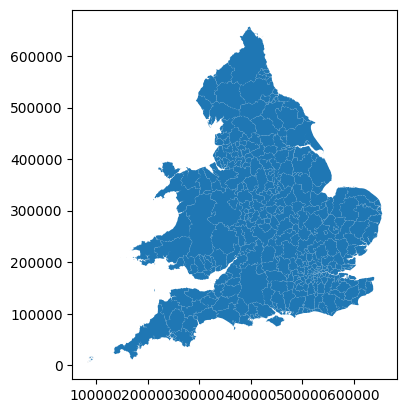

In [172]:
lads = gpd.read_file(f"{data_path}/ONS LAD Boundaries December 2011/Local_Authority_Districts_December_2011_GCB_EW.shp")
lads.plot()

In [173]:
lads.head()

,lad11cd,lad11cdo,lad11nm,lad11nmw,GlobalID,geometry
0,E06000001,00EB,Hartlepool,None,45cea71e-8eb0-4efd-90d2-9c1536bfca3a,"MULTIPOLYGON (((447096.998 537151.999, 447228...."
1,E06000002,00EC,Middlesbrough,None,9779de87-50fe-42de-aa75-b129d59b97b5,"MULTIPOLYGON (((449861.8 521260.701, 449853.7 ..."
2,E06000003,00EE,Redcar and Cleveland,None,dfb30422-8d7f-470e-a488-bdad9ec15068,"MULTIPOLYGON (((455776.699 528322.5, 455684.19..."
3,E06000004,00EF,Stockton-on-Tees,None,7b938653-4113-4df1-a5dd-81004fd413a4,"MULTIPOLYGON (((444110.4 528008.2, 444163.9 52..."
4,E06000005,00EH,Darlington,None,4745ddbb-6639-41f1-bfd7-dc19317f84f8,"POLYGON ((423496.6 524724.299, 423497.2 524675..."


<Axes: >

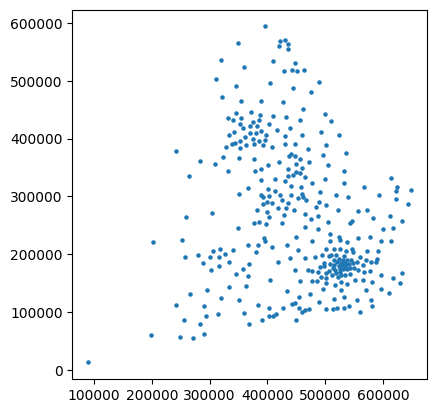

In [174]:
centroids = lads.centroid
centroids.plot(markersize=5)

In [175]:
centroid_distances = centroids.apply(lambda x: np.floor(centroids.distance(x)/1000).astype(int))
indices = range(len(lads.lad11cd.values))
index_to_lad = lads.lad11cd.values
centroid_distances.index = indices
centroid_distances.columns = indices
centroid_distances.head()

,0,1,2,3,4,5,6,7,8,9,...,338,339,340,341,342,343,344,345,346,347
0,0,14,20,12,23,175,165,134,149,117,...,386,374,365,359,347,351,340,362,297,354
1,14,0,13,7,21,165,154,124,142,104,...,374,362,354,347,335,339,327,349,286,342
2,20,13,0,20,34,174,163,134,154,98,...,380,368,360,354,342,345,333,355,294,349
3,12,7,20,0,14,162,152,121,138,110,...,373,361,353,346,334,338,327,349,284,341
4,23,21,34,14,0,154,144,112,126,118,...,366,355,346,340,328,332,321,343,276,334


In [176]:
LAD_RUC = (pd.read_csv(f"{data_path}/LAD Urban Rural Classification.csv")).dropna()
LAD_RUC['rural'] = LAD_RUC['RUC11CD'].apply(lambda x: True if x<=2 else False)
rural = set(LAD_RUC[LAD_RUC['rural']==True]['LAD11CD'].values)

## Flux events


In [177]:
import pandas as pd

In [178]:
next_flux = pd.read_csv(f"{data_path}/E_total_flux_next.csv")
next_flux.set_index('Unnamed: 0', inplace=True)
next_flux.head()
flux_lads = next_flux.columns.values


## Categorise distances
Group all LADs by distances in 1-100km bins.

In [179]:
rural_flux_bins =  pd.DataFrame(0, index=np.arange(101), columns=['count'])
urban_flux_bins = pd.DataFrame(0, index=np.arange(101), columns=['count'])
for coord in np.array(np.triu_indices(centroid_distances.shape[0], 1)).T:
  i,j = coord
  if(centroid_distances.iloc[i,j] > 0 and centroid_distances.iloc[i,j] <= 100
     and index_to_lad[i] in next_flux.index and index_to_lad[j] in next_flux.index):
    origin = index_to_lad[i]
    destination = index_to_lad[j]
    flux = next_flux.loc[origin,destination]
    if origin in rural:
      rural_flux_bins.iloc[centroid_distances.iloc[i,j]] += flux
    else:
      urban_flux_bins.iloc[centroid_distances.iloc[i,j]] += flux

# Normalise
rural_proportions = rural_flux_bins/rural_flux_bins.sum()
urban_proportions = urban_flux_bins/urban_flux_bins.sum()

# Age data
We need average contacts between age bins and then for each LAD an age breakdown for the *same* bins.


In [180]:
# Remove 00-04 and 05-09 from data since BBC Pandemic Census data doesn't have this data for population stratification.
polymod = pd.read_csv(f"{data_path}/GB Average Contacts Phys and NonPhys by Age.csv", index_col=0)[2::]
polymod.drop(['00-04', '05-09'], axis=1)

,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70
Age group,,,,,,,,,,,,,
10-14,6.85,1.52,0.27,0.31,0.48,0.76,1.00,0.69,0.32,0.44,0.27,0.41,0.33
15-19,1.03,6.71,1.58,0.73,0.42,0.56,0.85,1.16,0.70,0.30,0.20,0.48,0.63
20-24,0.22,0.93,2.59,1.49,0.75,0.63,0.77,0.87,0.88,0.61,0.53,0.37,0.33
25-29,0.44,0.74,1.29,1.83,0.97,0.71,0.74,0.85,0.88,0.87,0.67,0.74,0.33
30-34,0.62,0.50,0.88,1.19,1.67,0.89,1.02,0.91,0.92,0.61,0.76,0.63,0.27
35-39,1.26,1.09,0.76,0.95,1.53,1.50,1.32,1.09,0.83,0.69,1.02,0.96,0.20
40-44,1.14,0.94,0.73,0.88,0.82,1.23,1.35,1.27,0.89,0.67,0.94,0.81,0.80
45-49,0.57,0.77,0.97,0.93,0.57,0.80,1.32,1.87,0.61,0.80,0.61,0.59,0.57
50-54,0.40,0.41,0.44,0.85,0.60,0.61,0.71,0.95,0.74,1.06,0.59,0.56,0.57


In [181]:
year_stratification = pd.read_csv(f"{data_path}/ukmidyear_age.csv")[9::]
year_stratification.index = year_stratification['lad17cd']

In [182]:
year_stratification

,lad17cd,region,county,name,all,0,1,2,3,4,...,91,92,93,94,95,96,97,98,99,100
lad17cd,,,,,,,,,,,,,,,,,,,,,
E06000047,E06000047,NaN,County Durham UA,NaN,513242,5884,5645,5602,5826,5617,...,709,461,331,262,215,187,144,87,76,80
E06000005,E06000005,NaN,Darlington UA,NaN,105564,1344,1371,1302,1297,1265,...,148,104,91,69,50,34,26,32,22,28
E06000001,E06000001,NaN,Hartlepool UA,NaN,92028,1097,1176,1155,1159,1111,...,127,63,51,34,29,15,16,15,6,14
E06000002,E06000002,NaN,Middlesbrough UA,NaN,138412,1979,1965,1797,1863,1827,...,183,103,90,56,40,46,30,19,12,15
E06000057,E06000057,NaN,Northumberland UA,NaN,316028,3148,3150,3205,3325,3175,...,517,377,231,242,183,140,72,62,53,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95P,95P,NaN,NaN,Newry and Mourne,99480,1573,1563,1505,1580,1499,...,71,48,39,35,37,19,15,6,4,8
95U,95U,NaN,NaN,Newtownabbey,85139,1174,1192,1195,1212,1119,...,80,70,51,28,22,20,15,11,7,10
95W,95W,NaN,NaN,North Down,78937,958,934,977,981,915,...,140,100,70,46,46,36,26,16,10,13


In [189]:
def sum_ages(x, start, end):
  ages = [str(i) for i in range(start_age, end_age+1)]
  return x[ages].sum(axis=1)

In [190]:
lad_ages = year_stratification.loc[flux_lads]
binned_lad_ages = pd.DataFrame(0, index=lad_ages.index, columns=[])
for bin in range(12):
  start_age = 10+bin*5
  end_age = 9+(bin+1)*5
  binned_lad_ages[f"{start_age}-{end_age}"] = sum_ages(lad_ages, start_age, end_age)
# now do 70+
binned_lad_ages["70+"] = sum_ages(lad_ages, 70, 100)

In [191]:
binned_lad_ages

,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
lad17cd,,,,,,,,,,,,,
E06000001,5653,6278,5955,5622,5033,5373,6463,7267,6464,5595,5837,4236,4236
E06000002,8485,10064,11690,9765,8295,8135,8984,9899,9233,7933,7531,5680,5680
E06000003,7803,8835,8092,7628,6987,7654,9479,10398,9429,8458,9511,7776,7776
E06000004,11457,12819,12651,12602,11445,12003,14087,14644,13399,11609,11648,8745,8745
E06000005,6224,6408,6071,6607,6429,6847,7641,7994,7258,6308,6685,5205,5205
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E09000029,11673,11487,10657,13185,14303,14737,15413,14928,12274,10045,10366,7563,7563
E09000030,13202,14623,30818,40157,33028,21539,15678,11778,9736,7823,5863,4140,4140
E09000031,14760,15241,20604,26508,24168,21112,20243,17340,14321,11301,9783,7231,7231
